In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

#### Setting Options

In [2]:
# suppress display of warnings
warnings.filterwarnings('ignore')

In [3]:
import os
source_dir="./105_classes_pins_dataset"

<p style = "font-size:20px; color: #007580 "><strong> Function to load images </strong></p> 
- Define a function to load the images from the extracted folder and map each image with person id 


In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata(source_dir)

In [5]:
print('metadata shape :', metadata.shape)

metadata shape : (17555,)


In [6]:
metadata[17533]

./105_classes_pins_dataset\pins_Zoe Saldana\Zoe Saldana73_5039.jpg

In [7]:
type(metadata[17024]), metadata[17024].image_path()

(__main__.IdentityMetadata,
 './105_classes_pins_dataset\\pins_Wenyue Zhang\\Wenyue Zhang14_5076.jpg')

<p style = "font-size:20px; color: #007580 "><strong> Define a function to load an image </strong></p>
- Define a function to load image from the metadata

In [8]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [11]:
model = vgg_face()

model.load_weights('./vgg_face_weights.h5')

In [12]:
model.layers[0], model.layers[-2]

(<keras.layers.convolutional.ZeroPadding2D at 0x20081618d30>,
 <keras.layers.core.flatten.Flatten at 0x20096d39040>)

In [13]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [14]:
type(vgg_face_descriptor)

keras.engine.functional.Functional

In [15]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_13_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [16]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[17024].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [17]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.004899422, numpy.ndarray, numpy.float32)

In [18]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.0059449906, -0.016520726, 0.010025277)

In [19]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 17555


In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

In [20]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (17555, 2622)


In [21]:
embeddings[0], embeddings[988], embeddings[988].shape

(array([ 0.01242802, -0.00290049,  0.01809886, ..., -0.0427675 ,
         0.02089459,  0.05350694]),
 array([ 0.02542743, -0.01191231, -0.01609731, ..., -0.02832453,
         0.00920453,  0.00086766]),
 (2622,))

In [22]:
embeddings[17541]

array([ 0.01036416, -0.00796124,  0.00990442, ..., -0.00690572,
        0.01651695,  0.02963074])

In [23]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

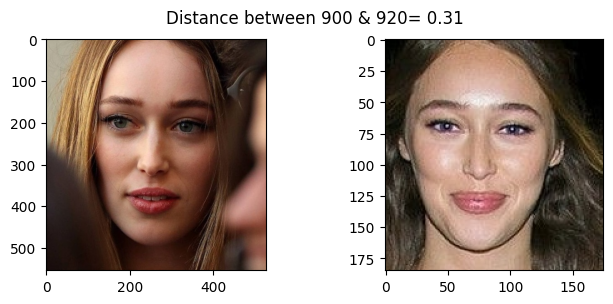

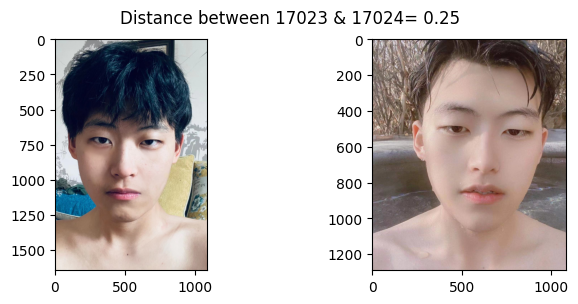

In [24]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(900, 920)
show_pair(17023, 17024)

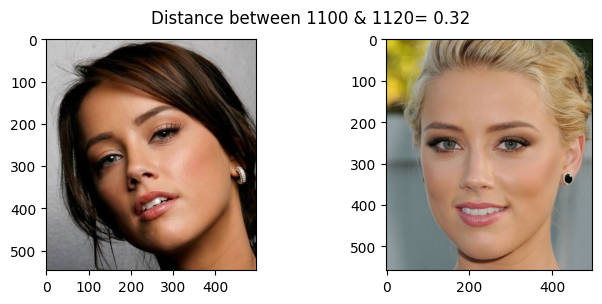

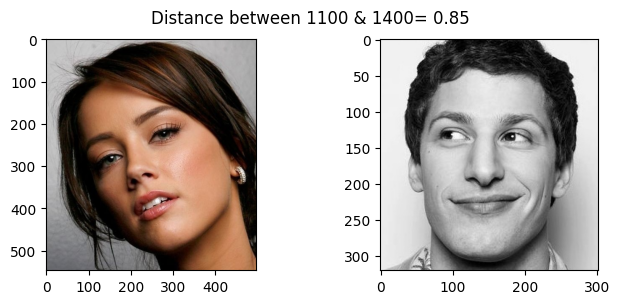

In [25]:
show_pair(1100, 1120)
show_pair(1100, 1400)

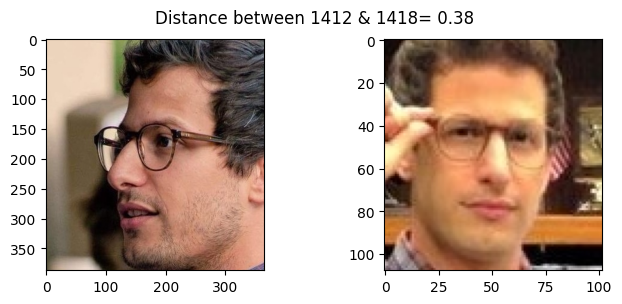

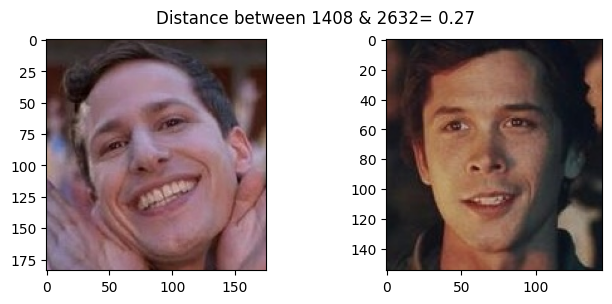

In [26]:
show_pair(1412, 1418)
show_pair(1408, 2632)

In [27]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [28]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (15604,2622)
y_train shape : (15604,)
X_test shape : (1951,2622)
y_test shape : (1951,)


In [29]:
y_test[0], y_train[988]

('pins_Adriana Lima', 'pins_amber heard')

In [30]:
len(np.unique(y_test)), len(np.unique(y_train))

(106, 106)

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [32]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Adriana Lima' 'pins_Alex Lawther' 'pins_Alexandra Daddario'
 'pins_Alvaro Morte' 'pins_Amanda Crew' 'pins_Andy Samberg'
 'pins_Anne Hathaway' 'pins_Anthony Mackie' 'pins_Avril Lavigne'
 'pins_Ben Affleck' 'pins_Bill Gates' 'pins_Bobby Morley'
 'pins_Brenton Thwaites' 'pins_Brian J. Smith' 'pins_Brie Larson'
 'pins_Chris Evans' 'pins_Chris Hemsworth' 'pins_Chris Pratt'
 'pins_Christian Bale' 'pins_Cristiano Ronaldo' 'pins_Danielle Panabaker'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Eliza Taylor'
 'pins_Elizabeth Lail' 'pins_Emilia Clarke' 'pins_Emma Stone'
 'pins_Emma Watson' 'pins_Gwyneth Paltrow' 'pins_Henry Cavil'
 'pins_Hugh Jackman' 'pins_Inbar Lavi' 'pins_Irina Shayk'
 'pins_Jake Mcdorman' 'pins_Jason Momoa' 'pins_Jennifer Lawrence'
 'pins_Jeremy Renner' 'pins_Jessica Barden' 'pins_Jimmy Fallon'
 'pins_Johnny Depp' 'pins_Josh Radnor' 'pins_Katharine Mcphee'
 'pins_Katherine Langford' 'pins_Keanu Reeves' 'pins_Krysten Ritter'
 'pins_Leonardo DiCaprio' 'pins_Lili R

In [33]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 0  0  0 ... 89 89 89]
y_test_encoded :  [ 0  0  0 ... 89 89 89]


<p style = "font-size:20px; color: #007580 "><strong> Standardize the feature values </strong></p> 
- Scale the features using StandardScaler

In [34]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [35]:
X_test_std = scaler.transform(X_test)

In [36]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (15604,2622)
y_train_encoded shape : (15604,)
X_test_std shape : (1951,2622)
y_test_encoded shape : (1951,)


In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [38]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [39]:
y_predict = clf.predict(X_test_pca)

In [40]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [  0 104   0 ...  89  89  89]
y_test_encoded :  [ 0  0  0 ... 89 89 89]


In [41]:
y_predict_encoded = le.inverse_transform(y_predict)

In [42]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['pins_Adriana Lima' 'pins_scarlett johansson' 'pins_Adriana Lima' ...
 'pins_Zoe Saldana' 'pins_Zoe Saldana' 'pins_Zoe Saldana']


In [43]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (1951,)
y_test_encoded shape :  (1951,)


In [44]:
y_test_encoded[32:49]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.9630958482829318

**Accuracy Score: 96.455%**

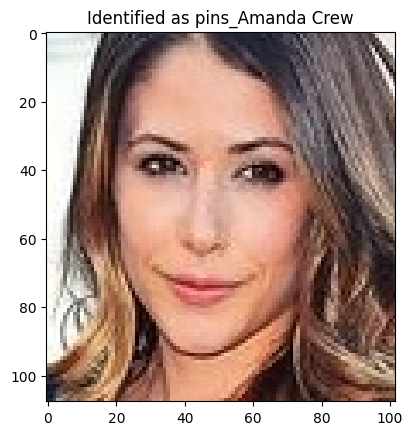

In [46]:
example_idx = 112

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

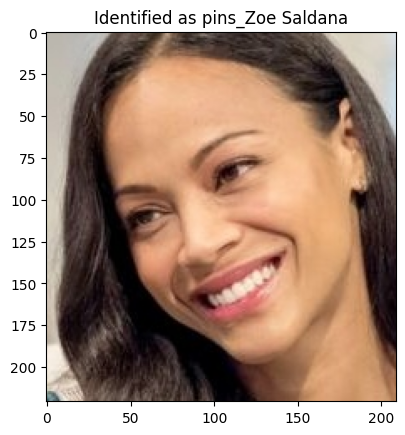

In [47]:
example_idx = 1948

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

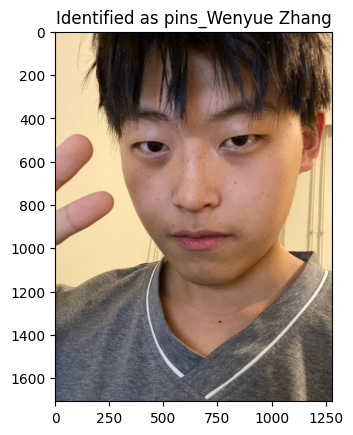

In [65]:
example_idx = 1892

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx] 
example_identity =  y_predict_encoded[example_idx] 

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

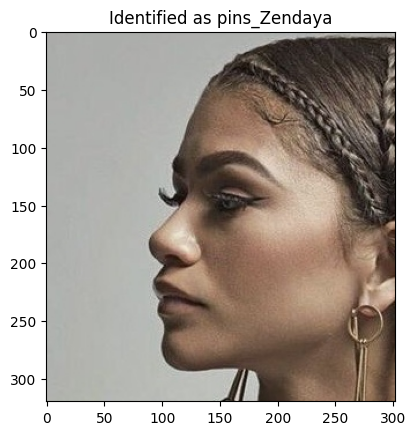

In [49]:
example_idx = -27

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');